In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.utils.data import sampler

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32

device

device(type='cuda')

In [6]:
train_transform = T.Compose([
                T.ToTensor(),                
                T.RandomHorizontalFlip(p=0.5),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
inv_transform = T.Compose([
                T.Normalize((0., 0., 0.), (1/0.2023, 1/0.1994, 1/0.2010)),
                T.Normalize((-0.4914, -0.4822, -0.4465), (1., 1. ,1. )),
                T.ToPILImage()
            ])
test_transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

NUM_TRAIN = 49000
ds_train = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=train_transform)
ds_test  = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=test_transform)

dl_train = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, NUM_TRAIN)))
dl_valid = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
dl_test  = DataLoader(ds_test,  batch_size=64)

splits = {
    "train": dl_train,
    "valid": dl_valid,
    "test": dl_test,
}

100%|██████████| 170498071/170498071 [00:09<00:00, 18046875.93it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


mean: -0.07
std: 1.28
max: 2.75
min: -2.43


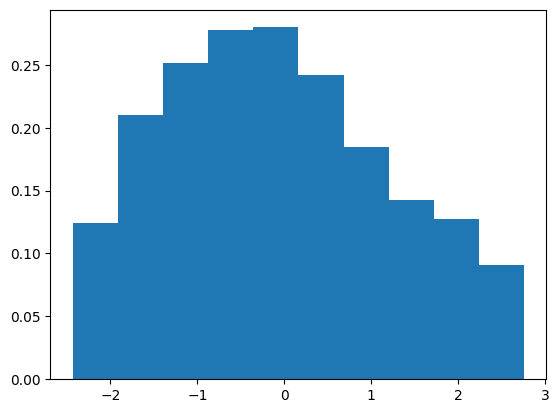

In [7]:
x, _ = next(iter(dl_train))
x = x.view(-1)
print(f"mean: {x.mean():.2f}")
print(f"std: {x.std():.2f}")
print(f"max: {x.max():.2f}")
print(f"min: {x.min():.2f}")

plt.hist(x, density=True);

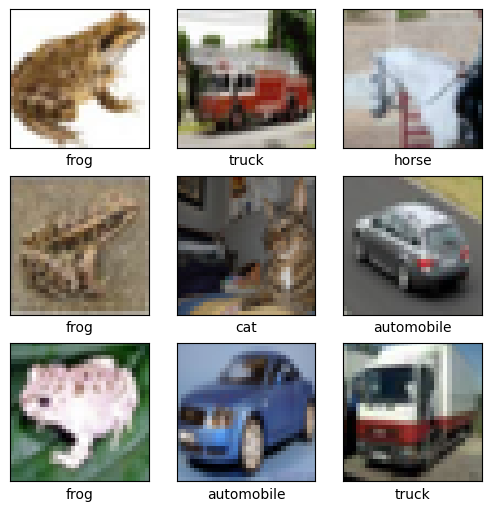

In [8]:
def plot_sample(xb, yb, pred=None):
    fig, axs = plt.subplots(3, 3, figsize=(5, 5), layout='constrained')

    for r in range(3):
        for c in range(3):
            ax = axs[r][c]
            x = xb[r*3 + c]
            y = yb[r*3 + c]
            x = inv_transform(x)
            ax.imshow(x)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel(ds_train.classes[y])

            if pred != None:
                yh = pred[r*3 + c]
                ax.set_xlabel(ds_train.classes[yh])

                if yh != y:
                    ax.xaxis.label.set_color('r')

xb, yb = next(iter(dl_train))
plot_sample(xb, yb)

# Model

In [57]:
class Block(nn.Module):
    def __init__(self, channel) -> None:
        super().__init__()
        channel_bneck = channel // 4

        self.residual = nn.Sequential(
            # conv 1x1
            nn.BatchNorm2d(channel),
            nn.ReLU(),
            nn.Conv2d(channel, channel_bneck, kernel_size=1),

            # conv 3x3
            nn.BatchNorm2d(channel_bneck),
            nn.ReLU(),
            nn.Conv2d(channel_bneck, channel_bneck, kernel_size=3, padding=1),

            # conv 1x1
            nn.BatchNorm2d(channel_bneck),
            nn.ReLU(),
            nn.Conv2d(channel_bneck, channel, kernel_size=1),
        )
        
    def forward(self, x):
        out = x + self.residual(x)
        return out


class ExpandBlock(nn.Module):
    def __init__(self, channel_in, channel_out, stride) -> None:
        super().__init__()
        channel_bneck = channel_out // 4

        self.pre_act = nn.Sequential(
            nn.BatchNorm2d(channel_in),
            nn.ReLU()
        )

        self.residual = nn.Sequential(
            # conv 1x1
            nn.Conv2d(channel_in, channel_bneck, kernel_size=1, stride=stride),

            # conv 3x3
            nn.BatchNorm2d(channel_bneck),
            nn.ReLU(),
            nn.Conv2d(channel_bneck, channel_bneck, kernel_size=3, padding=1),

            # conv 1x1
            nn.BatchNorm2d(channel_bneck),
            nn.ReLU(),
            nn.Conv2d(channel_bneck, channel_out, kernel_size=1),
        )

        self.identity = nn.Conv2d(channel_in, channel_out, kernel_size=1, stride=stride)
    
    def forward(self, x):
        x = self.pre_act(x)
        out = self.identity(x) + self.residual(x)
        return out


class ResNet(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), # size: 32
            ExpandBlock(16, 64, stride=1),
            Block(64),
            Block(64),
            Block(64),
            ExpandBlock(64, 128, stride=2),             # size: 16
            Block(128),
            Block(128),
            Block(128),
            ExpandBlock(128, 256, stride=2),            # size: 8
            Block(256),
            Block(256),
            Block(256),
            ExpandBlock(256, 512, stride=2),            # size: 4
            Block(512),
            Block(512),
            Block(512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=4),                # size: 1
            nn.Flatten(),
            nn.Linear(512, 10),
        )
        
        # for m in self.modules():
        #   if isinstance(m, nn.Conv2d):
        #       torch.nn.init.kaiming_normal_(m.weight, nonlinearity="relu", mode="fan_out")
        #       torch.nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.layers(x)


x, y = next(iter(dl_train))
model = ResNet()
yh = model(x)

print(f"parameter count: {sum([p.numel() for p in model.parameters()]):,}")

parameter count: 1,632,810


## Sanity Check

### Initial loss check

In [48]:
model = ResNet()
xb, yb = next(iter(dl_train))
yh = model(xb)
loss = F.cross_entropy(yh, yb)
loss.backward()

print("chance:", -torch.tensor(1/10).log().item())
print("loss:", loss.item())

chance: 2.3025851249694824
loss: 2.419956684112549


### Check if model has the capacity of overfit a small batch

In [58]:
model = ResNet()

xb, yb = next(iter(dl_train))
y = model(xb)
optimizer = torch.optim.Adam(model.parameters())
xb, yb = next(iter(dl_train))

model = model.to(device=device)
xb = xb.to(device=device)
yb = yb.to(device=device)

for i in range(1000):
    optimizer.zero_grad()
    yh = model(xb)
    loss = F.cross_entropy(yh, yb)
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(f"{loss.item():.4f}")

    if loss.item() < 1e-5:
        break

2.3242
0.0005
0.0003
0.0002
0.0001
0.0001
0.0001
0.0001
0.0000
0.0000


## Utility

In [59]:
@torch.no_grad()
def eval_split(split, model, sample_size=None):
    model.eval()
    dl = splits[split]

    num_correct = 0
    num_sample = 0
    lossi = []
    i = 0

    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device)

        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        lossi.append(loss.item())

        _, idx = logits.max(1)
        num_correct += (yb == idx).sum()
        num_sample += len(yb)

        i += len(xb)
        if sample_size and i >= sample_size:
            break

    accuracy = float(num_correct) / num_sample
    loss = torch.tensor(lossi).mean().item()
    model.train()

    return loss, accuracy

## Training

In [60]:
%%time

model = ResNet()
model = model.to(device=device)
model.train()

dl = splits["train"]
epoch = 5
i = 0
n = len(dl) * epoch

metrics = []
optimizer = torch.optim.AdamW(model.parameters())

for _ in range(epoch):
    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device)
        optimizer.zero_grad()

        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        loss.backward()
        
        if i % 40 == 0:
            tr_loss, tr_acc = eval_split("train", model, sample_size=1024)
            va_loss, va_acc = eval_split("valid", model, sample_size=1024)
            metrics.append((tr_loss, tr_acc, va_loss, va_acc))
            print(f"{int(i/n*100)}%: {tr_loss:.2f} {va_loss:.2f} {tr_acc:.2f} {va_acc:.2f}")
        
        i += 1
        optimizer.step()

0%: 2.30 2.30 0.11 0.12
1%: 2.09 2.17 0.23 0.22
2%: 1.75 1.71 0.38 0.40
3%: 1.71 1.65 0.37 0.39
4%: 1.55 1.55 0.43 0.44
5%: 1.52 1.51 0.45 0.46
6%: 1.64 1.66 0.41 0.41
7%: 1.41 1.45 0.50 0.49
8%: 1.46 1.48 0.48 0.48
9%: 1.34 1.33 0.51 0.52
10%: 1.26 1.30 0.55 0.53
11%: 1.33 1.25 0.53 0.54
12%: 1.36 1.41 0.50 0.49
13%: 1.18 1.22 0.58 0.55
14%: 1.24 1.24 0.57 0.57
15%: 1.22 1.25 0.57 0.55
16%: 1.17 1.18 0.58 0.58
17%: 1.23 1.26 0.56 0.54
18%: 1.13 1.10 0.59 0.61
19%: 1.11 1.10 0.60 0.61
20%: 1.25 1.27 0.55 0.56
21%: 1.03 1.04 0.62 0.63
22%: 1.09 1.05 0.61 0.63
24%: 1.06 1.07 0.61 0.62
25%: 0.99 1.03 0.65 0.64
26%: 0.95 1.02 0.67 0.64
27%: 1.02 0.96 0.63 0.67
28%: 1.01 1.06 0.65 0.64
29%: 0.93 0.93 0.67 0.67
30%: 1.05 1.01 0.62 0.66
31%: 0.91 0.96 0.67 0.66
32%: 1.00 1.02 0.66 0.66
33%: 0.87 0.89 0.70 0.69
34%: 0.85 0.90 0.70 0.69
35%: 0.88 0.93 0.67 0.68
36%: 0.93 0.90 0.68 0.68
37%: 0.85 0.87 0.70 0.69
38%: 0.81 0.90 0.71 0.69
39%: 0.87 0.94 0.69 0.66
40%: 0.81 0.85 0.70 0.71
41%: 0.94 

In [62]:
tr_loss, tr_acc = eval_split("train", model)
va_loss, va_acc = eval_split("valid", model)

print(f"train: {tr_loss:.2f} {tr_acc:.2f}")
print(f"valid: {va_loss:.2f} {va_acc:.2f}")

train: 0.61 0.79
valid: 0.71 0.77


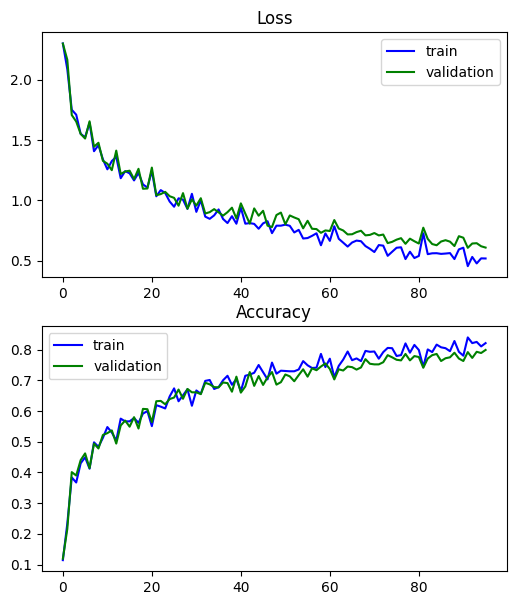

In [64]:
# plot loss and accuracy, one on left and another on the right
tr_loss, tr_acc, va_loss, va_acc = zip(*metrics)

plt.figure(figsize=(6, 7))

plt.subplot(2, 1, 1)
plt.plot(tr_loss, label="train", color="b")
plt.plot(va_loss, label="validation", color="g")
plt.title("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tr_acc, label="train", color="b")
plt.plot(va_acc, label="validation", color="g")
plt.title("Accuracy")
plt.legend()

In [ ]:
@torch.no_grad()
def predict(x):
    model.eval()
    x = x.to(device=device, dtype=dtype)
    logits = model(x)
    prob = F.softmax(logits, dim=1)
    yh = torch.argmax(prob, dim=1)
    model.train()
    return yh

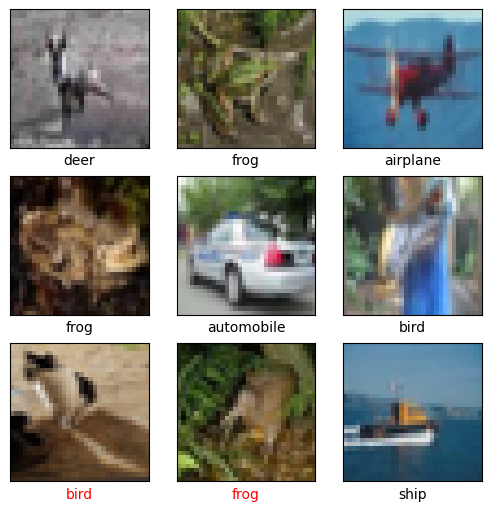

In [ ]:
xb, yb = next(iter(dl_valid))
pred = predict(xb)

plot_sample(xb, yb, pred)

In [ ]:
eval_split("test", model)

(0.6432514190673828, 0.7822)